In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  
        self.fc2 = nn.Linear(128, 1)  # One output node for binary classification
        self.sigmoid = nn.Sigmoid()  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool
        x = torch.flatten(x, 1)  # Flatten for FC layers
        x = F.relu(self.fc1(x))  # Fully Connected Layer 1
        x = self.sigmoid(self.fc2(x))  # Output Layer (Sigmoid for binary classification)
        return x

In [2]:
import torch as torch

def train(net, trainloader, optimizer, device):
    criterion = torch.nn.BCELoss()
    net.to(device)
    net.train()
    running_loss = 0.0
    total = 0
    for batch in trainloader:
        images, labels = batch["image"].to(device), batch["label"].to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        running_loss += loss.item()
    
    #print(f"Loss: {running_loss/len(trainloader):.4f}")

    return running_loss / len(trainloader)

def test(net, testloader, device):
    """Validate the network on the entire test set."""
    criterion = torch.nn.BCELoss()
    correct, loss = 0, 0.0
    net.to(device)
    net.eval()
    total = 0

    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"].to(device), batch["label"].to(device).float().unsqueeze(1)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            preds = outputs > 0.5
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total

    return loss / len(testloader), accuracy

In [3]:
from datasets import load_dataset

dataset_path = "dataset/colon_image_sets"
ds = load_dataset("imagefolder", data_dir=dataset_path)

Resolving data files:   0%|          | 0/10000 [00:00<?, ?it/s]

In [4]:
dataset = ds['train'].shuffle(seed=42)

In [5]:
from flwr_datasets.partitioner import DirichletPartitioner
from flwr_datasets.partitioner import IidPartitioner

NUM_PARTITIONS = 3
alpha = 0.95

partitioner = DirichletPartitioner(
    num_partitions=NUM_PARTITIONS, 
    partition_by="label", 
    alpha=alpha, 
    min_partition_size=10,
    seed=42
)
#partitioner = IidPartitioner(num_partitions=NUM_PARTITIONS)

partitioner.dataset = dataset

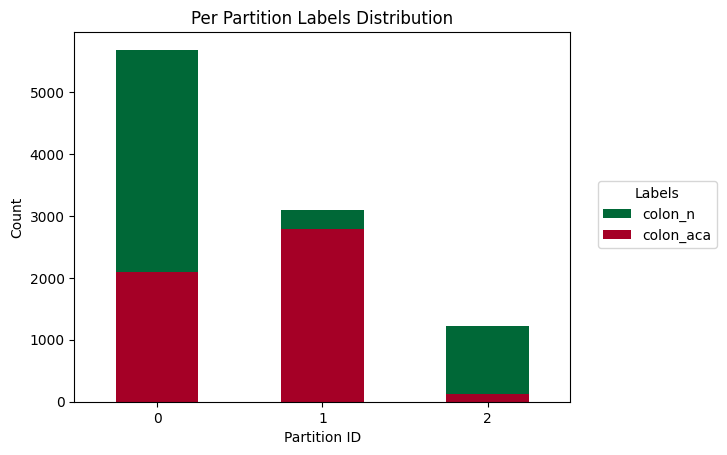

In [6]:
from flwr_datasets.visualization import plot_label_distributions

fig, ax, df = plot_label_distributions(
    partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    max_num_partitions=30,  # Note we are only showing the first 30 so the plot remains readable
    title="Per Partition Labels Distribution",
)

In [7]:
from collections import OrderedDict
from typing import Dict, Tuple

import torch
from flwr.common import NDArrays, Scalar
from flwr.client import NumPyClient


class FlowerClient(NumPyClient):
    def __init__(self, trainloader, valloader, id) -> None:
        super().__init__()

        self.trainloader = trainloader
        self.valloader = valloader
        self.id = id
        self.model = Net()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def fit(self, parameters, config):
        """This method trains the model using the parameters sent by the
        server on the dataset of this client. At then end, the parameters
        of the locally trained model are communicated back to the server"""

        # copy parameters sent by the server into client's local model
        set_params(self.model, parameters)

        # Define the optimizer
        optim = torch.optim.Adam(self.model.parameters(), lr=0.001)

        # do local training (call same function as centralised setting)
        train(self.model, self.trainloader, optim, self.device)

        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return get_params(self.model), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """Evaluate the model sent by the server on this client's
        local validation set. Then return performance metrics."""

        set_params(self.model, parameters)
        # do local evaluation (call same function as centralised setting)
        loss, accuracy = test(self.model, self.valloader, self.device)
        # send statistics back to the server
        return float(loss), len(self.valloader), {"accuracy": accuracy, "loss": loss, 'id': self.id}


# Two auxhiliary functions to set and extract parameters of a model
def set_params(model, parameters):
    """Replace model parameters with those passed as `parameters`."""

    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.from_numpy(v) for k, v in params_dict})
    # now replace the parameters
    model.load_state_dict(state_dict, strict=True)


def get_params(model):
    """Extract model parameters as a list of NumPy arrays."""
    return [val.cpu().numpy() for _, val in model.state_dict().items()]

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Normalize, Compose

torch.manual_seed(42)
g = torch.Generator()
g.manual_seed(42)

def get_dataloaders(dataset, batch_size: int):
    pytorch_transforms = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
    ])

    # Prepare transformation functions
    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
        return batch

    train = dataset["train"].with_transform(apply_transforms)
    test = dataset["test"].with_transform(apply_transforms)

    # Construct PyTorch dataloaders
    trainloader = DataLoader(train, batch_size=batch_size, shuffle=True, generator=g)
    testloader = DataLoader(test, batch_size=batch_size)
    return trainloader, testloader

In [9]:
from flwr.common import Context
from flwr.client import ClientApp


def client_fn(context: Context):
    """Returns a FlowerClient containing its data partition."""

    partition_id = int(context.node_config["partition-id"])
    partition = partitioner.load_partition(partition_id)
    partition_train_val = partition.train_test_split(test_size=0.2, seed=42)
    trainloader, testloader = get_dataloaders(partition_train_val, batch_size=32)

    return FlowerClient(trainloader=trainloader, valloader=testloader, id=partition_id).to_client()

# Concstruct the ClientApp passing the client generation function
client_app = ClientApp(client_fn=client_fn)

In [10]:
from typing import List
from flwr.common import Metrics

client_metrics = []

# Define metric aggregation function
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    client_metrics.append(metrics)
    print(metrics)
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [11]:
from flwr.common import ndarrays_to_parameters
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg

num_rounds = 80

def server_fn(context: Context):

    # instantiate the model
    model = Net()
    ndarrays = get_params(model)
    # Convert model parameters to flwr.common.Parameters
    global_model_init = ndarrays_to_parameters(ndarrays)

    # Define the strategy
    strategy = FedAvg(
        fraction_fit=1.0,  # 10% clients sampled each round to do fit()
        fraction_evaluate=1.0,  # 50% clients sample each round to do evaluate()
        evaluate_metrics_aggregation_fn=weighted_average,  # callback defined earlier
        initial_parameters=global_model_init,  # initialised global model
    )

    # Construct ServerConfig
    config = ServerConfig(num_rounds=num_rounds)

    # Wrap everything into a `ServerAppComponents` object
    return ServerAppComponents(strategy=strategy, config=config)


# Create your ServerApp
server_app = ServerApp(server_fn=server_fn)

In [12]:
from flwr.simulation import run_simulation

run_simulation(
    server_app=server_app, client_app=client_app, num_supernodes=NUM_PARTITIONS
)

INFO :      Starting Flower ServerApp, config: num_rounds=80, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
2025-04-08 11:54:38,218	WARNING services.py:2009 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67100672 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.14gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
(ClientAppActor pid=30360) /home/codespace/.local/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWa

[(8, {'accuracy': 0.9061224489795918, 'loss': 0.6238479614257812, 'id': 2}), (20, {'accuracy': 0.6106623586429726, 'loss': 0.6743659228086472, 'id': 1}), (36, {'accuracy': 0.8038698328935796, 'loss': 0.6464061074786716, 'id': 0})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.38786279683377306, 'loss': 0.9875248819589615, 'id': 0}), (8, {'accuracy': 0.08571428571428572, 'loss': 1.3595547527074814, 'id': 2}), (20, {'accuracy': 0.8901453957996769, 'loss': 0.354601875692606, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.5567282321899736, 'loss': 0.6429487607545323, 'id': 0}), (20, {'accuracy': 0.8449111470113085, 'loss': 0.40663227885961534, 'id': 1}), (8, {'accuracy': 0.42448979591836733, 'loss': 0.7682546079158783, 'id': 2})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.48021108179419525, 'loss': 0.7414911033378707, 'id': 0}), (20, {'accuracy': 0.8675282714054927, 'loss': 0.31367966830730437, 'id': 1}), (8, {'accuracy': 0.2653061224489796, 'loss': 0.9743982404470444, 'id': 2})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(20, {'accuracy': 0.8578352180936996, 'loss': 0.3373853273689747, 'id': 1}), (36, {'accuracy': 0.7801231310466139, 'loss': 0.5105591010716226, 'id': 0}), (8, {'accuracy': 0.7428571428571429, 'loss': 0.5990883037447929, 'id': 2})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(8, {'accuracy': 0.8775510204081632, 'loss': 0.47308415174484253, 'id': 2}), (36, {'accuracy': 0.8408091468777484, 'loss': 0.4357333870397674, 'id': 0}), (20, {'accuracy': 0.8336025848142165, 'loss': 0.3499052166938782, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.8390501319261213, 'loss': 0.4384833400448163, 'id': 0}), (8, {'accuracy': 0.8612244897959184, 'loss': 0.4938594922423363, 'id': 2}), (20, {'accuracy': 0.8546042003231018, 'loss': 0.31717539504170417, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(8, {'accuracy': 0.5836734693877551, 'loss': 0.7937428578734398, 'id': 2}), (36, {'accuracy': 0.6640281442392261, 'loss': 0.6053423426217504, 'id': 0}), (20, {'accuracy': 0.8949919224555735, 'loss': 0.23788100220263003, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(8, {'accuracy': 0.9183673469387755, 'loss': 0.35632436722517014, 'id': 2}), (20, {'accuracy': 0.7948303715670436, 'loss': 0.3701055094599724, 'id': 1}), (36, {'accuracy': 0.8583992963940194, 'loss': 0.36889853907956016, 'id': 0})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.8161829375549692, 'loss': 0.4534766947229703, 'id': 0}), (20, {'accuracy': 0.8739903069466882, 'loss': 0.26191636398434637, 'id': 1}), (8, {'accuracy': 0.8081632653061225, 'loss': 0.5333407707512379, 'id': 2})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.8522427440633246, 'loss': 0.402358863916662, 'id': 0}), (8, {'accuracy': 0.8653061224489796, 'loss': 0.45585983991622925, 'id': 2}), (20, {'accuracy': 0.875605815831987, 'loss': 0.2620329838246107, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(20, {'accuracy': 0.8869143780290791, 'loss': 0.22861932814121247, 'id': 1}), (36, {'accuracy': 0.8153034300791556, 'loss': 0.4476469535794523, 'id': 0}), (8, {'accuracy': 0.7959183673469388, 'loss': 0.5398573540151119, 'id': 2})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(8, {'accuracy': 0.8530612244897959, 'loss': 0.45218194276094437, 'id': 2}), (20, {'accuracy': 0.8852988691437803, 'loss': 0.2401961963623762, 'id': 1}), (36, {'accuracy': 0.8443271767810027, 'loss': 0.3952234515713321, 'id': 0})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.8601583113456465, 'loss': 0.3611375643975205, 'id': 0}), (8, {'accuracy': 0.8816326530612245, 'loss': 0.39469804242253304, 'id': 2}), (20, {'accuracy': 0.875605815831987, 'loss': 0.250233843177557, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(20, {'accuracy': 0.8998384491114702, 'loss': 0.1926129300147295, 'id': 1}), (36, {'accuracy': 0.7695690413368513, 'loss': 0.49055636384420925, 'id': 0}), (8, {'accuracy': 0.7306122448979592, 'loss': 0.6264274343848228, 'id': 2})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(8, {'accuracy': 0.8938775510204081, 'loss': 0.32697857171297073, 'id': 2}), (36, {'accuracy': 0.8663148636763413, 'loss': 0.32057538049088585, 'id': 0}), (20, {'accuracy': 0.8691437802907916, 'loss': 0.25799315571784975, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(20, {'accuracy': 0.9079159935379645, 'loss': 0.2001996522769332, 'id': 1}), (36, {'accuracy': 0.8328935795954265, 'loss': 0.40488025380505455, 'id': 0}), (8, {'accuracy': 0.8122448979591836, 'loss': 0.48930440098047256, 'id': 2})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(20, {'accuracy': 0.8723747980613893, 'loss': 0.25574783720076083, 'id': 1}), (8, {'accuracy': 0.889795918367347, 'loss': 0.3173662833869457, 'id': 2}), (36, {'accuracy': 0.8715919085312225, 'loss': 0.3097422512041198, 'id': 0})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.8583992963940194, 'loss': 0.3386072835160626, 'id': 0}), (20, {'accuracy': 0.8852988691437803, 'loss': 0.22748201042413713, 'id': 1}), (8, {'accuracy': 0.8693877551020408, 'loss': 0.37230289727449417, 'id': 2})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(8, {'accuracy': 0.8448979591836735, 'loss': 0.3951275832951069, 'id': 2}), (36, {'accuracy': 0.8601583113456465, 'loss': 0.3403504685395294, 'id': 0}), (20, {'accuracy': 0.8982229402261712, 'loss': 0.213451131246984, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(20, {'accuracy': 0.8933764135702746, 'loss': 0.21519719175994395, 'id': 1}), (8, {'accuracy': 0.8938775510204081, 'loss': 0.3420525211840868, 'id': 2}), (36, {'accuracy': 0.8795074758135444, 'loss': 0.3050275809235043, 'id': 0})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.8425681618293756, 'loss': 0.35412976973586613, 'id': 0}), (20, {'accuracy': 0.925686591276252, 'loss': 0.1685997350141406, 'id': 1}), (8, {'accuracy': 0.8204081632653061, 'loss': 0.4455568864941597, 'id': 2})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.8619173262972736, 'loss': 0.30591329994301003, 'id': 0}), (8, {'accuracy': 0.8530612244897959, 'loss': 0.34658797085285187, 'id': 2}), (20, {'accuracy': 0.8982229402261712, 'loss': 0.20002635940909386, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.8671943711521548, 'loss': 0.3060156787849135, 'id': 0}), (20, {'accuracy': 0.9176090468497576, 'loss': 0.17703487668186427, 'id': 1}), (8, {'accuracy': 0.8612244897959184, 'loss': 0.3714056611061096, 'id': 2})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(8, {'accuracy': 0.8326530612244898, 'loss': 0.4084203653037548, 'id': 2}), (20, {'accuracy': 0.9273021001615509, 'loss': 0.16743755685165523, 'id': 1}), (36, {'accuracy': 0.8408091468777484, 'loss': 0.3251630895667606, 'id': 0})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(8, {'accuracy': 0.9142857142857143, 'loss': 0.28710496984422207, 'id': 2}), (36, {'accuracy': 0.8988566402814424, 'loss': 0.2616006444311804, 'id': 0}), (20, {'accuracy': 0.901453957996769, 'loss': 0.21103761363774537, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(20, {'accuracy': 0.9224555735056543, 'loss': 0.1765855211764574, 'id': 1}), (36, {'accuracy': 0.8847845206684257, 'loss': 0.27348939660522675, 'id': 0}), (8, {'accuracy': 0.8775510204081632, 'loss': 0.3213109076023102, 'id': 2})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(20, {'accuracy': 0.9192245557350566, 'loss': 0.1881662955507636, 'id': 1}), (36, {'accuracy': 0.8918205804749341, 'loss': 0.2681011596901549, 'id': 0}), (8, {'accuracy': 0.9020408163265307, 'loss': 0.3191336039453745, 'id': 2})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.911169744942832, 'loss': 0.21703459694981575, 'id': 0}), (8, {'accuracy': 0.9224489795918367, 'loss': 0.2256473135203123, 'id': 2}), (20, {'accuracy': 0.9111470113085622, 'loss': 0.19468894377350807, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(8, {'accuracy': 0.9346938775510204, 'loss': 0.23860624618828297, 'id': 2}), (36, {'accuracy': 0.9190853122251539, 'loss': 0.2134261102312141, 'id': 0}), (20, {'accuracy': 0.925686591276252, 'loss': 0.1599582045339048, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(8, {'accuracy': 0.926530612244898, 'loss': 0.24976767040789127, 'id': 2}), (36, {'accuracy': 0.9138082673702727, 'loss': 0.21642778917319244, 'id': 0}), (20, {'accuracy': 0.9418416801292407, 'loss': 0.14699365459382535, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(8, {'accuracy': 0.9510204081632653, 'loss': 0.1986057348549366, 'id': 2}), (20, {'accuracy': 0.9305331179321487, 'loss': 0.16707440558820963, 'id': 1}), (36, {'accuracy': 0.9322779243623571, 'loss': 0.1885990999225113, 'id': 0})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(8, {'accuracy': 0.9551020408163265, 'loss': 0.18626793660223484, 'id': 2}), (36, {'accuracy': 0.9252418645558487, 'loss': 0.18925189992619884, 'id': 0}), (20, {'accuracy': 0.9127625201938611, 'loss': 0.1972663619555533, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(8, {'accuracy': 0.926530612244898, 'loss': 0.2056714091449976, 'id': 2}), (36, {'accuracy': 0.9261213720316622, 'loss': 0.19272518758144644, 'id': 0}), (20, {'accuracy': 0.9418416801292407, 'loss': 0.14228128530085088, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.9375549692172384, 'loss': 0.16684979365931618, 'id': 0}), (8, {'accuracy': 0.9591836734693877, 'loss': 0.16290875058621168, 'id': 2}), (20, {'accuracy': 0.9289176090468497, 'loss': 0.1712607047520578, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.9349164467897977, 'loss': 0.15790940676298407, 'id': 0}), (8, {'accuracy': 0.9755102040816327, 'loss': 0.1281428737565875, 'id': 2}), (20, {'accuracy': 0.9095315024232633, 'loss': 0.21410079915076494, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.940193491644679, 'loss': 0.15757209745546183, 'id': 0}), (8, {'accuracy': 0.9673469387755103, 'loss': 0.15233679860830307, 'id': 2}), (20, {'accuracy': 0.9273021001615509, 'loss': 0.16896760016679763, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(20, {'accuracy': 0.938610662358643, 'loss': 0.15074486676603555, 'id': 1}), (36, {'accuracy': 0.9375549692172384, 'loss': 0.16363664199080732, 'id': 0}), (8, {'accuracy': 0.9591836734693877, 'loss': 0.17190429754555225, 'id': 2})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(8, {'accuracy': 0.9428571428571428, 'loss': 0.17599602602422237, 'id': 2}), (36, {'accuracy': 0.9366754617414248, 'loss': 0.1602238468411896, 'id': 0}), (20, {'accuracy': 0.9563812600969306, 'loss': 0.126127066090703, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(8, {'accuracy': 0.963265306122449, 'loss': 0.15783761255443096, 'id': 2}), (36, {'accuracy': 0.9428320140721196, 'loss': 0.1512157479301095, 'id': 0}), (20, {'accuracy': 0.9466882067851373, 'loss': 0.13937081806361676, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(20, {'accuracy': 0.9531502423263328, 'loss': 0.12432961212471128, 'id': 1}), (36, {'accuracy': 0.9287598944591029, 'loss': 0.1798809292829699, 'id': 0}), (8, {'accuracy': 0.9428571428571428, 'loss': 0.20902723632752895, 'id': 2})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(20, {'accuracy': 0.9434571890145396, 'loss': 0.14551593400537968, 'id': 1}), (8, {'accuracy': 0.963265306122449, 'loss': 0.16663041710853577, 'id': 2}), (36, {'accuracy': 0.9410729991204925, 'loss': 0.15099450894114044, 'id': 0})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.9489885664028144, 'loss': 0.13109061401337385, 'id': 0}), (8, {'accuracy': 0.9673469387755103, 'loss': 0.13126403838396072, 'id': 2}), (20, {'accuracy': 0.9450726978998385, 'loss': 0.1392803114373237, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(8, {'accuracy': 0.9755102040816327, 'loss': 0.11751472018659115, 'id': 2}), (20, {'accuracy': 0.9402261712439418, 'loss': 0.16168116368353366, 'id': 1}), (36, {'accuracy': 0.951627088830255, 'loss': 0.12679800308412975, 'id': 0})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(20, {'accuracy': 0.9563812600969306, 'loss': 0.12018172550015152, 'id': 1}), (36, {'accuracy': 0.9481090589270009, 'loss': 0.13955418941461378, 'id': 0}), (8, {'accuracy': 0.9469387755102041, 'loss': 0.15554768219590187, 'id': 2})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(8, {'accuracy': 0.9142857142857143, 'loss': 0.26059849187731743, 'id': 2}), (36, {'accuracy': 0.9085312225153914, 'loss': 0.20800326102309757, 'id': 0}), (20, {'accuracy': 0.9596122778675282, 'loss': 0.11627239668741822, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.9349164467897977, 'loss': 0.1629368272713489, 'id': 0}), (20, {'accuracy': 0.9579967689822294, 'loss': 0.12337745311670005, 'id': 1}), (8, {'accuracy': 0.9346938775510204, 'loss': 0.1986361127346754, 'id': 2})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.9489885664028144, 'loss': 0.13586921979569727, 'id': 0}), (20, {'accuracy': 0.9418416801292407, 'loss': 0.16909773787483573, 'id': 1}), (8, {'accuracy': 0.9551020408163265, 'loss': 0.14180520828813314, 'id': 2})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(20, {'accuracy': 0.9466882067851373, 'loss': 0.16481700595468282, 'id': 1}), (8, {'accuracy': 0.963265306122449, 'loss': 0.12999082589522004, 'id': 2}), (36, {'accuracy': 0.9463500439753738, 'loss': 0.13212957522935337, 'id': 0})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 51]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(20, {'accuracy': 0.9596122778675282, 'loss': 0.12201049779541791, 'id': 1}), (36, {'accuracy': 0.951627088830255, 'loss': 0.1315284964835478, 'id': 0}), (8, {'accuracy': 0.963265306122449, 'loss': 0.14131990261375904, 'id': 2})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 52]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(8, {'accuracy': 0.9755102040816327, 'loss': 0.10921296058222651, 'id': 2}), (36, {'accuracy': 0.9489885664028144, 'loss': 0.12507776393451625, 'id': 0}), (20, {'accuracy': 0.9531502423263328, 'loss': 0.165475660469383, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 53]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.9428320140721196, 'loss': 0.1511676998084618, 'id': 0}), (8, {'accuracy': 0.9469387755102041, 'loss': 0.17697641626000404, 'id': 2}), (20, {'accuracy': 0.9596122778675282, 'loss': 0.10864743435522542, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 54]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.9507475813544415, 'loss': 0.134000089743899, 'id': 0}), (8, {'accuracy': 0.963265306122449, 'loss': 0.1397944218479097, 'id': 2}), (20, {'accuracy': 0.9531502423263328, 'loss': 0.13301447129342706, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 55]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.9525065963060686, 'loss': 0.11870688140495783, 'id': 0}), (8, {'accuracy': 0.963265306122449, 'loss': 0.1063906189519912, 'id': 2}), (20, {'accuracy': 0.9466882067851373, 'loss': 0.1677389180287719, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 56]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.9551451187335093, 'loss': 0.13030842854641378, 'id': 0}), (8, {'accuracy': 0.963265306122449, 'loss': 0.14683172944933176, 'id': 2}), (20, {'accuracy': 0.9596122778675282, 'loss': 0.10940422608982772, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 57]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(20, {'accuracy': 0.9224555735056543, 'loss': 0.21868816195055843, 'id': 1}), (8, {'accuracy': 0.9836734693877551, 'loss': 0.07703032647259533, 'id': 2}), (36, {'accuracy': 0.9569041336851363, 'loss': 0.11040589715250665, 'id': 0})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 58]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.9384344766930519, 'loss': 0.1477079485129151, 'id': 0}), (8, {'accuracy': 0.9346938775510204, 'loss': 0.20385756250470877, 'id': 2}), (20, {'accuracy': 0.9612277867528272, 'loss': 0.10123122441582381, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 59]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.9384344766930519, 'loss': 0.15020111468361896, 'id': 0}), (20, {'accuracy': 0.9515347334410339, 'loss': 0.1232175970915705, 'id': 1}), (8, {'accuracy': 0.9346938775510204, 'loss': 0.17243394628167152, 'id': 2})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 60]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.899736147757256, 'loss': 0.22645491444402271, 'id': 0}), (8, {'accuracy': 0.8816326530612245, 'loss': 0.31595880538225174, 'id': 2}), (20, {'accuracy': 0.9418416801292407, 'loss': 0.1311557305511087, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 61]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(20, {'accuracy': 0.9434571890145396, 'loss': 0.1584637166466564, 'id': 1}), (8, {'accuracy': 0.9673469387755103, 'loss': 0.0920505691319704, 'id': 2}), (36, {'accuracy': 0.9569041336851363, 'loss': 0.10825837024539295, 'id': 0})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 62]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(8, {'accuracy': 0.9469387755102041, 'loss': 0.14428504556417465, 'id': 2}), (20, {'accuracy': 0.9176090468497576, 'loss': 0.23665708359330892, 'id': 1}), (36, {'accuracy': 0.93051890941073, 'loss': 0.16246471440212595, 'id': 0})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 63]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(8, {'accuracy': 0.9755102040816327, 'loss': 0.07639865844976157, 'id': 2}), (20, {'accuracy': 0.925686591276252, 'loss': 0.22155376644805075, 'id': 1}), (36, {'accuracy': 0.9507475813544415, 'loss': 0.13311625530736315, 'id': 0})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 64]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.9525065963060686, 'loss': 0.12538653114137965, 'id': 0}), (20, {'accuracy': 0.9402261712439418, 'loss': 0.17369251160416752, 'id': 1}), (8, {'accuracy': 0.9591836734693877, 'loss': 0.12390450993552804, 'id': 2})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 65]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(20, {'accuracy': 0.9305331179321487, 'loss': 0.1921965003013611, 'id': 1}), (8, {'accuracy': 0.9795918367346939, 'loss': 0.0642675026319921, 'id': 2}), (36, {'accuracy': 0.9577836411609498, 'loss': 0.11315282606261058, 'id': 0})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 66]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(8, {'accuracy': 0.9346938775510204, 'loss': 0.20611661579459906, 'id': 2}), (36, {'accuracy': 0.941952506596306, 'loss': 0.15202918488325345, 'id': 0}), (20, {'accuracy': 0.9693053311793215, 'loss': 0.09087656091433019, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 67]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(20, {'accuracy': 0.9240710823909531, 'loss': 0.26843350678682326, 'id': 1}), (36, {'accuracy': 0.951627088830255, 'loss': 0.14985574598217177, 'id': 0}), (8, {'accuracy': 0.9877551020408163, 'loss': 0.08314304146915674, 'id': 2})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 68]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(8, {'accuracy': 0.9795918367346939, 'loss': 0.05673672037664801, 'id': 2}), (36, {'accuracy': 0.951627088830255, 'loss': 0.14144307175754672, 'id': 0}), (20, {'accuracy': 0.9240710823909531, 'loss': 0.26040661791339514, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 69]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.9586631486367634, 'loss': 0.11397662091379364, 'id': 0}), (8, {'accuracy': 0.9755102040816327, 'loss': 0.06992427119985223, 'id': 2}), (20, {'accuracy': 0.9208400646203554, 'loss': 0.2462549614254385, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 70]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(8, {'accuracy': 0.9183673469387755, 'loss': 0.2307223193347454, 'id': 2}), (36, {'accuracy': 0.940193491644679, 'loss': 0.1714217201418554, 'id': 0}), (20, {'accuracy': 0.9612277867528272, 'loss': 0.09991608092095702, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 71]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(8, {'accuracy': 0.9551020408163265, 'loss': 0.1047545273322612, 'id': 2}), (20, {'accuracy': 0.9547657512116317, 'loss': 0.14275051469448954, 'id': 1}), (36, {'accuracy': 0.9595426561125769, 'loss': 0.11089661500106256, 'id': 0})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 72]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(8, {'accuracy': 0.9755102040816327, 'loss': 0.08682043850421906, 'id': 2}), (36, {'accuracy': 0.9498680738786279, 'loss': 0.1300018350723096, 'id': 0}), (20, {'accuracy': 0.9240710823909531, 'loss': 0.23387806322425603, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 73]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.9533861037818822, 'loss': 0.1273686441838638, 'id': 0}), (20, {'accuracy': 0.9693053311793215, 'loss': 0.10320101201650686, 'id': 1}), (8, {'accuracy': 0.9428571428571428, 'loss': 0.17102810321375728, 'id': 2})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 74]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(8, {'accuracy': 0.889795918367347, 'loss': 0.37757583148777485, 'id': 2}), (20, {'accuracy': 0.9693053311793215, 'loss': 0.08083245127054398, 'id': 1}), (36, {'accuracy': 0.8883025505716798, 'loss': 0.2940152095009883, 'id': 0})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 75]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.9164467897977133, 'loss': 0.2292748033327775, 'id': 0}), (8, {'accuracy': 0.8693877551020408, 'loss': 0.3425258994102478, 'id': 2}), (20, {'accuracy': 0.9660743134087237, 'loss': 0.09744602452265098, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 76]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(8, {'accuracy': 0.9673469387755103, 'loss': 0.10253605688922107, 'id': 2}), (36, {'accuracy': 0.9481090589270009, 'loss': 0.14185526619742936, 'id': 0}), (20, {'accuracy': 0.9143780290791599, 'loss': 0.2921425480395555, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 77]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(8, {'accuracy': 0.963265306122449, 'loss': 0.12809656001627445, 'id': 2}), (36, {'accuracy': 0.9577836411609498, 'loss': 0.12155075971451071, 'id': 0}), (20, {'accuracy': 0.9612277867528272, 'loss': 0.13209340742323547, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 78]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(8, {'accuracy': 0.9551020408163265, 'loss': 0.09628987032920122, 'id': 2}), (20, {'accuracy': 0.9547657512116317, 'loss': 0.1602275462821126, 'id': 1}), (36, {'accuracy': 0.9586631486367634, 'loss': 0.12049707424982141, 'id': 0})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 79]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.909410729991205, 'loss': 0.26113132073078305, 'id': 0}), (8, {'accuracy': 0.8775510204081632, 'loss': 0.3694786708801985, 'id': 2}), (20, {'accuracy': 0.9612277867528272, 'loss': 0.10187643354001921, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 80]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)


[(36, {'accuracy': 0.9604221635883905, 'loss': 0.1207848261627886, 'id': 0}), (8, {'accuracy': 0.9673469387755103, 'loss': 0.07594346720725298, 'id': 2}), (20, {'accuracy': 0.9305331179321487, 'loss': 0.2641247765161097, 'id': 1})]


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 80 round(s) in 2512.94s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.6523237815126777
INFO :      		round 2: 0.8362401763442904
INFO :      		round 3: 0.584763091057539
INFO :      		round 4: 0.6369134220294654
INFO :      		round 5: 0.46750844712369144
INFO :      		round 6: 0.4135809293948114
INFO :      		round 7: 0.4074966262560338
INFO :      		round 8: 0.5140607381472364
INFO :      		round 9: 0.36770394584164023
INFO :      		round 10: 0.4035971008706838
INFO :      		round 11: 0.3651946483878419
INFO :      		round 12: 0.3907271206844598
INFO :      		round 13: 0.3538972457172349
INFO :      		round 14: 0.33067521126940846
INFO :      		round 15: 0.4144329245900735
INFO :      		round 16: 0.3018188341520

[(36, {'accuracy': 0.9322779243623571, 'loss': 0.16900641865666127, 'id': 0}), (20, {'accuracy': 0.9644588045234249, 'loss': 0.11888549831928685, 'id': 1}), (8, {'accuracy': 0.9306122448979591, 'loss': 0.23515492118895054, 'id': 2})]


(ClientAppActor pid=30361) /home/codespace/.local/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=30361)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


In [13]:
client_accs = [[] for _ in range(len(client_metrics[0]))]  # List of lists to store accuracies for each client
client_losses = [[] for _ in range(len(client_metrics[0]))]  # List of lists to store losses for each client

# Loop through each round of experiment (outer list)
for round_data in client_metrics:
    # Loop through each client (inner list)
    for client_idx, (_, metrics) in enumerate(round_data):
        # Append the accuracy and loss for the current client in this round
        client_accs[metrics['id']].append(metrics['accuracy'])
        client_losses[metrics['id']].append(metrics['loss'])

In [21]:
def weighted_avg(row, metric='loss'):
    partial = [num_examples * m[metric] for num_examples, m in row]
    examples = [num_examples for num_examples, _ in row]
    return sum(partial) / sum(examples)

weighted_loss = [weighted_avg(round) for round in client_metrics]
weighted_acc = [weighted_avg(round, 'accuracy') for round in client_metrics]

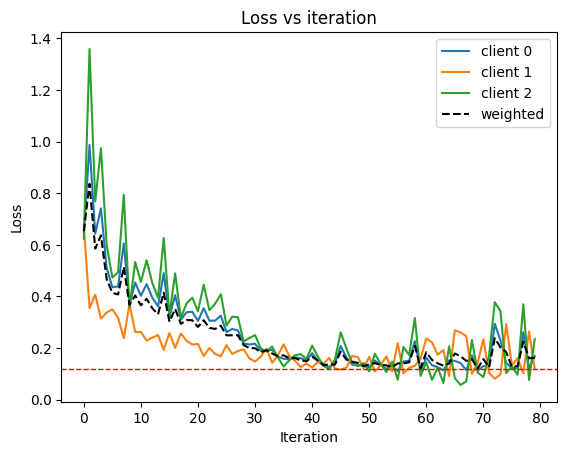

In [10]:
import matplotlib.pyplot as plt

# Create the line plot
for i, client in enumerate(client_losses):
    plt.plot(client, label='client ' + str(i))
plt.plot(weighted_loss, linestyle='--', color='black', label='weighted')
plt.axhline(y=0.12, color='r', linestyle='--', linewidth=1)
plt.title("Loss vs iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

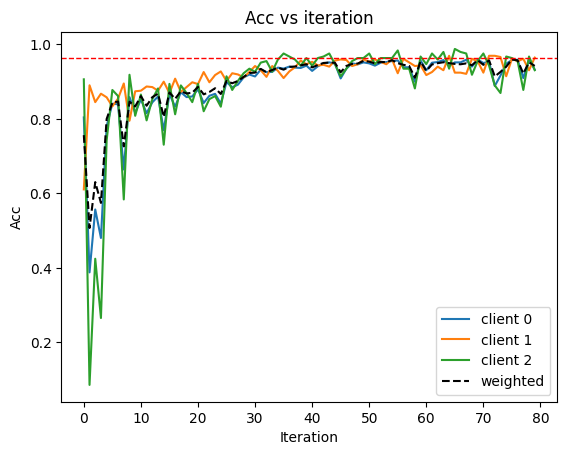

In [6]:
import matplotlib.pyplot as plt

# Create the line plot
for i, client in enumerate(client_accs):
    plt.plot(client, label='client ' + str(i))
plt.plot(weighted_acc, linestyle='--', color='black', label='weighted')
plt.axhline(y=0.964, color='r', linestyle='--', linewidth=1)
plt.title("Acc vs iteration")
plt.xlabel("Iteration")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [24]:
import json

to_save = {
    'accuracy': client_accs, 
    'loss': client_losses, 
    'weighted_acc': weighted_acc, 
    'weighted_loss': weighted_loss}

with open('non-iid.json', 'w') as f:
    json.dump(to_save, f)

In [2]:
import json

with open('non-iid.json', 'r') as f:
    loaded = json.load(f)

client_accs = loaded['accuracy']
client_losses = loaded['loss']
weighted_acc = loaded['weighted_acc']
weighted_loss = loaded['weighted_loss']